In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import scipy.io as sio
import  ca_source_extraction 

print 'imported'

imported


In [2]:
from matplotlib import pyplot as plt
from time import time,sleep
import pylab as pl
from scipy.sparse import coo_matrix
import scipy
from sklearn.decomposition import NMF
from ca_source_extraction.initialization import greedyROI2d, hals_2D,arpfit
from ca_source_extraction.spatial import update_spatial_components
from ca_source_extraction.temporal import update_temporal_components
from ca_source_extraction.merging import mergeROIS
from ca_source_extraction.utilities import *

print 'imported'

imported



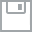
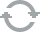
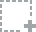
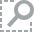
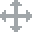
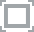
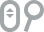
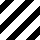
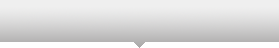
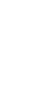
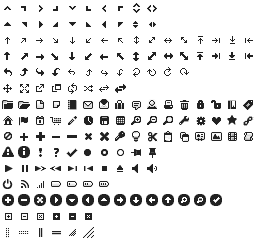
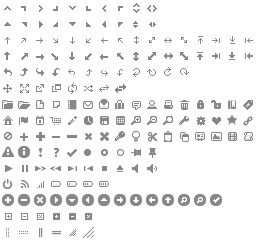
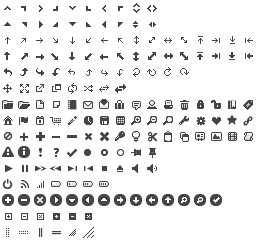
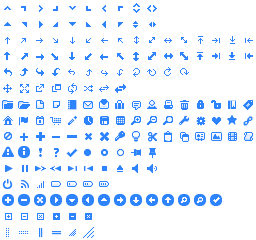
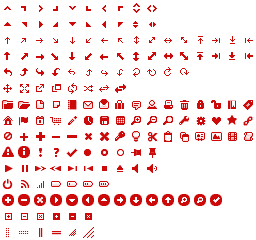
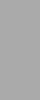
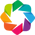
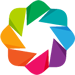

In [3]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider


from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np


bpl.output_notebook()

In [4]:
import calblitz as cb
print 'imported'

imported


In [5]:
# LOAD MOVIE AND MAKE DIMENSIONS COMPATIBLE WITH CNMF
m=cb.load('movies/demoMovie.tif',fr=8); 
T,h,w=np.shape(m)
Y=np.asarray(m)
Y = np.transpose(Y,(1,2,0))
d1,d2,T = np.shape(Y)

In [6]:
nr = 30
t1 = time()

Ain,Cin,_, b_in, f_in = greedyROI2d(Y, nr = nr, gSig = [4,4], gSiz = [9,9], use_median = False)
t_elGREEDY = time()-t1
Ain, Cin, b_in, f_in = hals_2D(Y, Ain, Cin, b_in, f_in,maxIter=10);

center = com(Ain,d1,d2);

clear_output(wait=True)
sleep(1)
print('DONE!')

DONE!


In [7]:
Cn = local_correlations(Y)

In [8]:
colormap =cm.get_cmap("jet") #choose any matplotlib colormap here
grayp = [mpl.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]

#p = bpl.figure(x_range=[0, Cn.shape[1]], y_range=[0, Cn.shape[0]])

p = bpl.figure(x_range=[0,Cn.shape[1]], y_range=[0,Cn.shape[0]])


p.image(image=[Cn], x=0, y=0, dw=Cn.shape[1], dh=Cn.shape[0], palette=grayp)

p.circle(center[:,1],center[:,0], size=10, color="black", fill_color=None, line_width=2, alpha=1)

bpl.show(p)

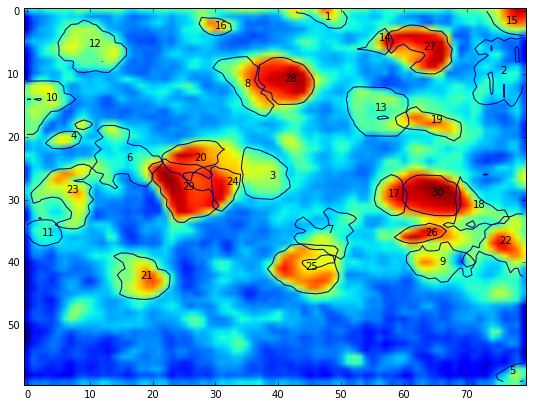

In [9]:
plt.figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
crd = plot_contours(coo_matrix(Ain[:,::-1]),Cn,thr=0.9)

In [10]:
active_pixels = np.squeeze(np.nonzero(np.sum(Ain,axis=1)))
Yr = np.reshape(Y,(d1*d2,T),order='F')
p = 1;
P = arpfit(Yr,p=1,pixels = active_pixels)
Y_res = Yr - np.dot(Ain,Cin)
model = NMF(n_components=1, init='random', random_state=0)
model.fit(np.maximum(Y_res,0))
fin = model.components_.squeeze()
print('DONE!')

DONE!


In [11]:

t1 = time()
A,b,Cin = update_spatial_components(Yr, Cin, fin, Ain, d1=d1, d2=d2, sn = P['sn'],dist=2,max_size=8,min_size=3)
t_elSPATIAL = time() - t1

clear_output(wait=True)
print('DONE!')

DONE!


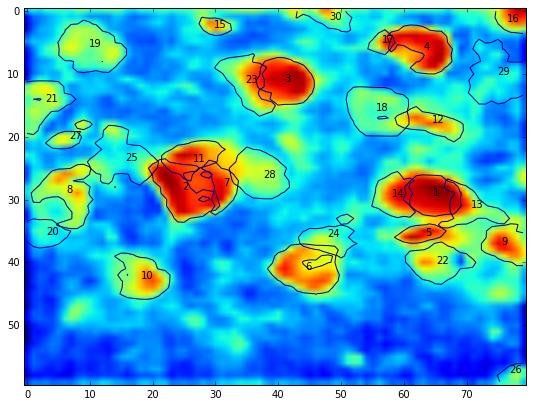

In [12]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = plot_contours(A,Cn,thr=0.9)

In [14]:
t1 = time()
C,f,Y_res,Pnew,S = update_temporal_components(Yr,A,b,Cin,fin,ITER=2,deconv_method = 'debug')
t_elTEMPORAL2 = time() - t1

clear_output(wait=True)
print('DONE!')

DONE!


In [15]:
t1 = time()
A_sp=A.tocsc();
A_m,C_m,nr_m,merged_ROIs,P_m,S=mergeROIS(Y_res,A_sp,b,np.array(C),f,d1,d2,Pnew,sn=P['sn'],thr=.85,deconv_method='debug',min_size=3,max_size=8,dist=2)
t_elMERGE = time() - t1

clear_output(wait=True)
print('DONE!')

DONE!


In [17]:
#%%
A2,b2,C_m_ = update_spatial_components(Yr, C_m, f, A_m, d1=d1, d2=d2, sn = P['sn'],dist=2,max_size=8,min_size=3)
C2,f2,Y_res2,Pnew2,S = update_temporal_components(Yr,A2,b2,C_m_,f,ITER=2,deconv_method = 'debug')

clear_output(wait=True)
print('DONE!')

DONE!


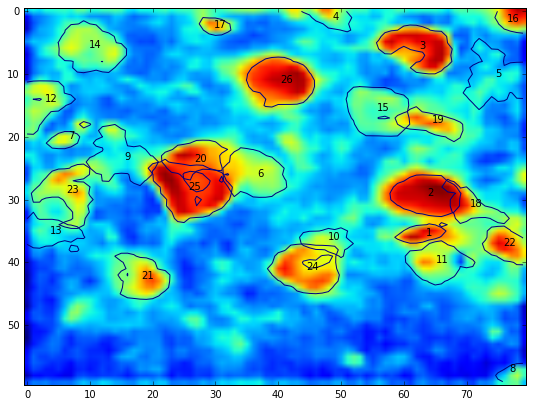

In [18]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
A_or, C_or, srt = order_components(A2,C2)
C_df = extract_DF_F(Yr,A2,C2)
crd = plot_contours(coo_matrix(A_or[:,::-1]),Cn,thr=0.9)

In [19]:
nr,T = C_or.shape
nA2 = np.sum(np.array(A_or)**2,axis=0)
Y_r = np.array(spdiags(1/nA2,0,nr,nr)*(A_or.T*np.matrix(Yr-b[:,np.newaxis]*f[np.newaxis])) + C_or)
#Cn=np.reshape(np.array(A_or)[:,0],(d1,d2),order='F')
#fig = plt.figure()
#plt.imshow(Cn,interpolation='None')

In [20]:
fig= plt.figure()
coors= plot_contours(coo_matrix(A_or),Cn,thr = 0.9)
plt.close()


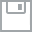
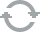
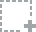
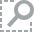
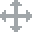
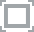
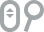
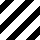
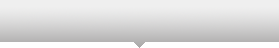
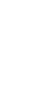
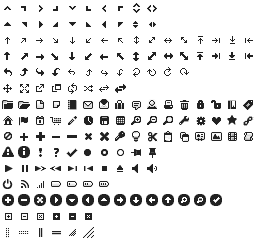
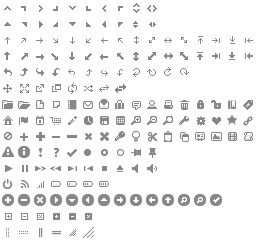
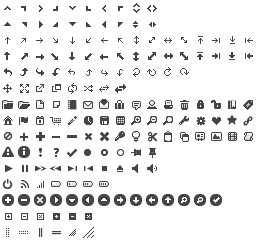
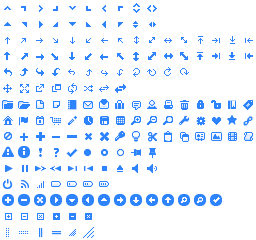
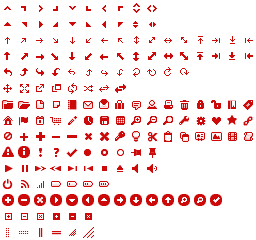
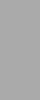
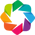
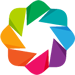

ERROR:/Users/agiovannucci/anaconda/envs/calblitz/lib/python2.7/site-packages/bokeh/validation/check.pyc:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 06671e64-8023-4d3b-ba8a-9341916f4ff0


In [21]:

%matplotlib inline

idneurons=np.arange(d1)
bpl.output_notebook()
x = np.arange(T)
z=np.squeeze(np.array(Y_r[:,:].T))/100
k=np.reshape(np.array(A_or),(d1,d2,A_or.shape[1]),order='F')

cc=coors[0]['coordinates'];
cc1=[cor['coordinates'][:,0] for cor in coors]
cc2=[cor['coordinates'][:,1] for cor in coors]
c1=cc1[0]
c2=cc2[0]
npoints=range(len(c1))

source = ColumnDataSource(data=dict(x=x, y=z[:,0], z=z))

source2 = ColumnDataSource(data=dict(x=npoints,c1=c1,c2=c2,cc1=cc1,cc2=cc2))


plot = bpl.figure(plot_width=600, plot_height=300)
plot.line('x', 'y', source=source, line_width=1, line_alpha=0.6)

callback = CustomJS(args=dict(source=source,source2=source2), code="""
        var data = source.get('data');
        var f = cb_obj.get('value')
        x = data['x']
        y = data['y']
        z = data['z']
        
        for (i = 0; i < x.length; i++) {
            y[i] = z[i][f-1]             
        }
        
        var data2 = source2.get('data');
        c1 = data2['c1'];
        c2 = data2['c2'];
        cc1 = data2['cc1'];
        cc2 = data2['cc2'];
        
        for (i = 0; i < c1.length; i++) {            
               c1[i] = cc1[f][i]
               c2[i] = cc2[f][i]            
        }
        source2.trigger('change');
        source.trigger('change');
        
    """)


slider = Slider(start=1, end=Y_r.shape[0], value=1, step=1, title="Neuron Number", callback=callback)

plot1 = bpl.figure(x_range=[0, d2], y_range=[0, d1],plot_width=300, plot_height=300)
plot1.image(image=[np.sum(k,axis=2)], x=0, y=0, dw=d2, dh=d1, palette=grayp)
plot1.patch('c1','c2',alpha=0.6, color='red',line_width=2,source=source2)

layout = vform(slider, hplot(plot1,plot))

bpl.show(layout)


In [ ]:
stop here!!

In [ ]:
idneuron=10


Cn=np.reshape(np.array(A_or)[:,idneuron],(d1,d2),order='F')
p1 = bpl.figure(x_range=[0, Cn.shape[1]], y_range=[0, Cn.shape[0]],plot_width=500, plot_height=500)
p1.image(image=[Cn], x=0, y=0, dw=Cn.shape[1], dh=Cn.shape[0], palette=grayp)
p2 = bpl.figure(x_range=[0, T], y_range=[0, 100000],plot_width=500, plot_height=500)

#plt.plot(np.arange(T),np.squeeze(np.array(Y_r[i,:]))) 
            #plt.plot(np.arange(T),np.squeeze(np.array(C[i,:])))
p2.line(np.arange(T),np.squeeze(np.array(Y_r[idneuron,:])), legend="Temp.", line_width=2)

#p2.plot(image=[Cn], x=0, y=0, dw=Cn.shape[1], dh=Cn.shape[0], palette=grayp)

p = gridplot([[p1,p2]], toolbar_location=None)



bpl.show(p)



from bokeh.io import vform,hplot,vplot,gridplot
from bokeh.models import CustomJS, ColumnDataSource, Slider

%matplotlib inline

x = np.arange(T)

z=np.squeeze(np.array(Y_r[:,:].T))/100


source = ColumnDataSource(data=dict(x=x, y=z[:,0], z=z))

plot = bpl.figure(plot_width=400, plot_height=300)
plot.line('x', 'y', source=source, line_width=1, line_alpha=0.6)

callback = CustomJS(args=dict(source=source), code="""
        var data = source.get('data');
        var f = cb_obj.get('value')
        x = data['x']
        y = data['y']
        z = data['z']
        for (i = 0; i < x.length; i++) {
            y[i] = z[i][f-1]
        }
        source.trigger('change');
    """)

slider = Slider(start=1, end=Y_r.shape[0], value=1, step=1, title="power", callback=callback)

plot1 = bpl.figure(plot_width=400, plot_height=300)
plot1.line('x', 'y', source=source, line_width=1, line_alpha=0.6)

layout = vform(slider, hplot(plot,plot1))
#layout = gridplot([[slider,None],[plot, plot1]])
#layout = gridplot([[plot, plot1], [None, slider]])
#p = gridplot([[s1, s2], [None, s3]])


bpl.show(layout)

#pl.plot(x,y)

coors= plot_contours(coo_matrix(A_or),Cn,thr = 0.9)
cc=coors[0]['coordinates']
cc1=cc[:,0];
cc2=cc[:,1];
cc1=[cor['coordinates'][:,0] for cor in coors]
cc2=[cor['coordinates'][:,1] for cor in coors]

cc=coors[0]['coordinates'];
c1=cc1[0]
c2=cc2[0]
npoints=range(len(c1))

npoints